# 3DeeCellTracker Demo

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import warnings
warnings.filterwarnings('ignore')
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.measurements as snm
from scipy.stats import trim_mean
import tensorflow as tf
from keras.backend import tensorflow_backend
from keras.models import load_model
from PIL import Image
from skimage.segmentation import relabel_sequential
from skimage.measure import label
import matplotlib as mpl
mpl.rcParams['image.interpolation']='none'

from CellTracker.unet3d import unet3_a, unet3_prediction
from CellTracker.watershed import watershed_2d_markers
from CellTracker.tracker import make_folders, segmentation, save_img3, displacement_image_to_real, \
    read_segmentation, interpolate, save_img3ts, get_subregions, match, track_one_vol

%matplotlib inline


Using TensorFlow backend.


# ++ Set the Global parameters ++

In [2]:
# parameters according to imaging conditions
par_image = {"volume_num": 1,  # number of volumes the 3D + T image
             "x_siz": 458,  # size of each 3D image
             "y_siz": 1021,  # size of each 3D image
             "z_siz": 50,  # size of each 3D image
             # the (rough) resolution ratio between the z axis and the x-y plane
             "z_xy_ratio": (458+1021)/50,
             # (integer; >=1) for interpolating images along z. z_scaling = 1 makes no interpolation.
             "z_scaling": 2,
             # <(input sizes of u-net)/2, pad and shrink for u-net prediction
             "shrink": (24, 24, 2),
             "miss_frame": []  # frames that cannot be processed
             }

# parameters manually determined by experience
par_tracker = {"noise_level": 20,  # a threshold to discriminate noise/artifacts from cells
               "min_size": 100,  # a threshold to remove small objects which may be noise/artifacts
               "BETA": 300,  # control coherence using a weighted average of movements of nearby points;
               # larger BETA includes more points, thus generates more coherent movements
               "LAMBDA": 0.1,  # control coherence by adding a loss of incoherence, large LAMBDA
               # generates larger penalty for incoherence.
               # maximum number of iterations; large values generate more accurate tracking.
               "max_iteration": 20,
               "ensemble": False,  # use ensemble mode (False: single mode; value: number of predictions to make)
               "adjacent": False  # irrelevant in single mode
               }

# parameters of paths/names
par_path = {"folder_path": os.path.abspath("./worm1"),  # path of the folder storing related files
            "files_name": "data_t%03i_z%03i.tif",  # file names for the raw image files
            # file names for the manaul segmentation files at t=1
            "manual_name": "manual_labels%03i.tif",
            # weight file of the trained 3D U-Net. f2b:structure a; fS2a:b; fS2b:c
            "unet_weight_file": "unet3_f2b_weights.hdf5",
            "FFN_weight_file": "FFN_model.h5"  # weight file of the trained FFN model
            }
# Make folders for data, models, result, etc.
make_folders(par_path, par_tracker["ensemble"], par_tracker["adjacent"])

# ++ Add data and model files to the folders before going to the next step ++

# Generate automatic segmetation of volume 1

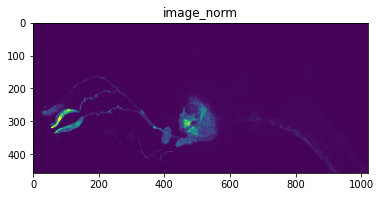

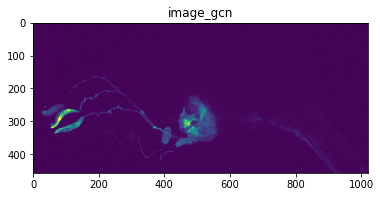

(1021, 458, 50)


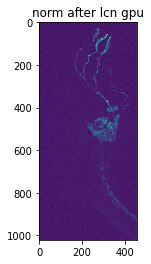

(1, 1021, 458, 50, 1)
(1021, 458, 50)


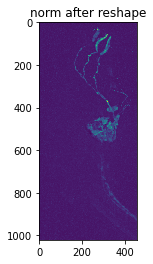

(1021, 458, 50)


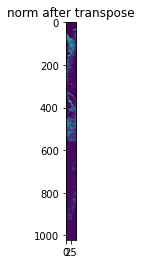

pre-processing took 10.6 s
segmentation took 53.1 s
Left: cell regions at t=1 by U-Net; Right: auto-segmentation at t=1


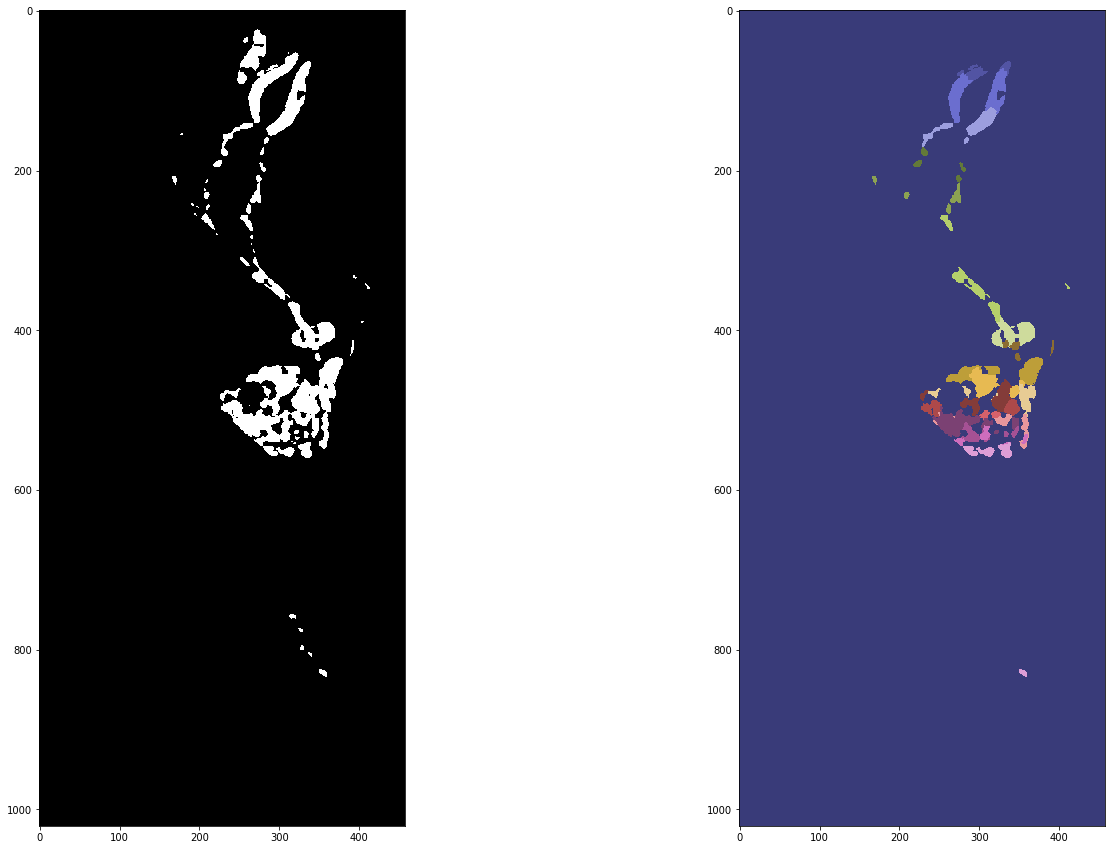

In [8]:
# load 3D unet model
volume = 1

# config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
# session = tf.Session(config=config)

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
session = tf.Session(config=config)

tensorflow_backend.set_session(session)
unet_model = unet3_a()
unet_model.load_weights(os.path.join(
    par_path["models_path"], par_path["unet_weight_file"]))

# segment 3D image of volume #1
image_cell_bg, l_center_coordinates, segmentation_auto, image_gcn = \
    segmentation(1, par_image, par_tracker, par_path,
                 unet_model, method="min_size", neuron_num=0)
# save the segmented cells of volume #1
# save_img3(z_siz_=par_image["z_siz"], img=segmentation_auto,
#           path="/home/kushal/Sars_stuff/metm_3d/a1_t3_gcamp_stack.export/CF 488.tif.export/split/" + "a1_t3_gcamp_stack%04.tif")
# transform the coordinate from voxel scale to real scale
# r_coordinates_segment_pre = displacement_image_to_real(
#     l_center_coordinates, par_image)

# draw predicted cell regions and segmentation at t=1 (2D projection)
print("Left: cell regions at t=1 by U-Net; Right: auto-segmentation at t=1")
plt.figure(figsize=(23, 15))
plt.subplot(1, 2, 1)
fig = plt.imshow(
    np.max(image_cell_bg[0, :, :, :, 0], axis=2) > 0.5, cmap="gray")
plt.subplot(1, 2, 2)
fig = plt.imshow(np.max(segmentation_auto, axis=2), cmap="tab20b")

# 20169900/50/458/1021

# ++ Make manual segmentation based on the autosegmentation at t=1 ++

# Load manually corrected segmentation of volume 1 and interpolate it 

In [ ]:
# load manually corrected segmentation
segmentation_manual = read_segmentation(par_path["manual_segmentation_vol1_path"],
                                        par_path["manual_name"], [0, par_image["z_siz"]])
# relabel cells sequentially
segmentation_manual_relabels, fw, inv = relabel_sequential(segmentation_manual)

# interpolate layers in z axis
seg_cells_interpolated_corrected = interpolate(
    par_image, segmentation_manual_relabels)

# save labels in the first volume (interpolated)
save_img3ts(range((par_image["z_scaling"] + 1) // 2,
                  seg_cells_interpolated_corrected.shape[2] + 1,
                  par_image["z_scaling"]),
            seg_cells_interpolated_corrected,
            par_path["track_results_path"] + "track_results_t%04i_z%04i.tif", 1)

# calculate coordinates of cell centers at t=1
center_points_t1 = snm.center_of_mass(segmentation_manual_relabels > 0, segmentation_manual_relabels,
                                      range(1, segmentation_manual_relabels.max()+1))
r_coordinates_tracked_pre = displacement_image_to_real(
    center_points_t1, par_image)

# save a copy of the coordinates in volume 1
r_coordinates_tracked_pre_vol1 = r_coordinates_tracked_pre.copy()

# draw interpolated manual segmantation
print("\n manual segmentation at t=1")
plt.figure(figsize=(7, 4))
fig = plt.imshow(
    np.max(seg_cells_interpolated_corrected, axis=2), cmap="tab20b")

# Prepare for tracking

In [7]:
# Compute subregions of each cells for quick "accurate correction"
seg_16 = seg_cells_interpolated_corrected.astype("int16")

region_list, region_width, region_xyz_min = get_subregions(
    seg_16, seg_16.max())
pad_x, pad_y, pad_z = np.max(region_width, axis=0)
label_padding = np.pad(seg_16, pad_width=((pad_x, pad_x), (pad_y, pad_y),
                                          (pad_z, pad_z)), mode='constant')*0

par_subregions = {"region_list": region_list,
                  "region_width": region_width,
                  "region_xyz_min": region_xyz_min,
                  "pad_x": pad_x,
                  "pad_y": pad_y,
                  "pad_z": pad_z,
                  "label_padding": label_padding
                  }
# test if there are multiple cells marked as a single region
for i, region in enumerate(region_list):
    if np.sum(np.unique(label(region))) > 1:
        print("more than one cell in region ", i+1)

# load FFN model
FFN_model = load_model(os.path.join(
    par_path["models_path"], par_path["FFN_weight_file"]))
# initialize all variables
r_displacement_from_vol1 = r_coordinates_tracked_pre*0
cells_on_boundary = r_displacement_from_vol1[:, 0].astype(int)
r_displacements = []
r_segmented_coordinates = []
r_segmented_coordinates.append(r_coordinates_segment_pre)
r_tracked_coordinates = []
r_tracked_coordinates.append(r_coordinates_tracked_pre)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 

OSError: Unable to open file (unable to open file: name = '/home/kushal/repos/3DeeCellTracker/Tracking_notebooks/worm1/models/FFN_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Test FFN + PR-GLS + Accurate correction between current volume (vol1) and another volume (using single mode)

t=50
segmentation took 7.1 s
fnn + pr-gls took 3.3 s
cells on boundary: []
FFN + PR-GLS: Left: x-y; Right: x-z


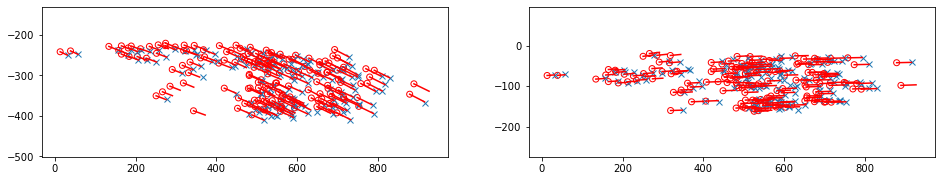

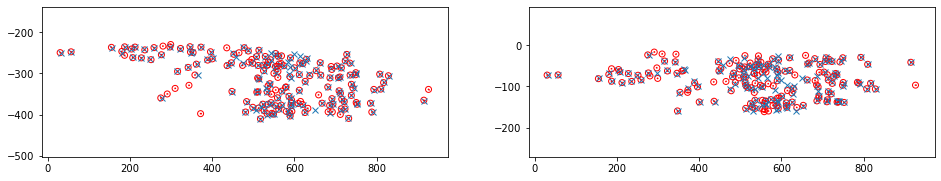

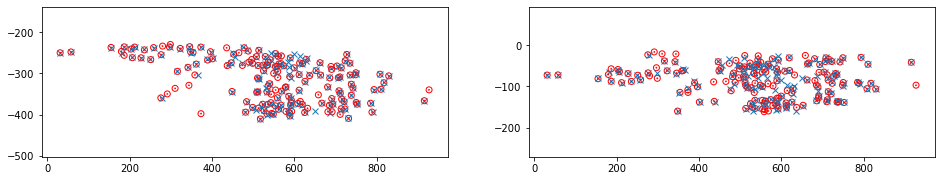

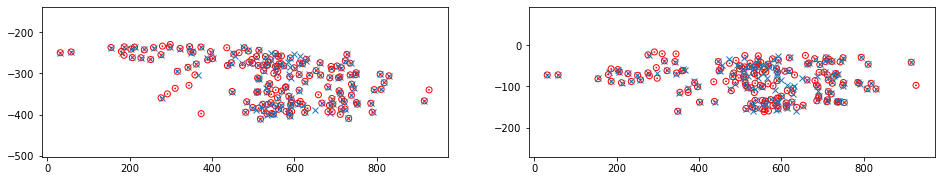

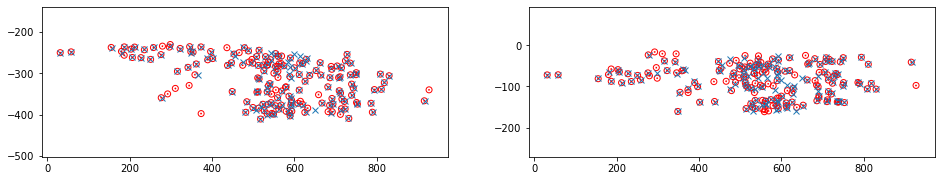

Accurate correction:
max correction: 4.837007107779527,4.760629741482659,1.6280738475124281,2.062496104762408,0.7725548659267929,

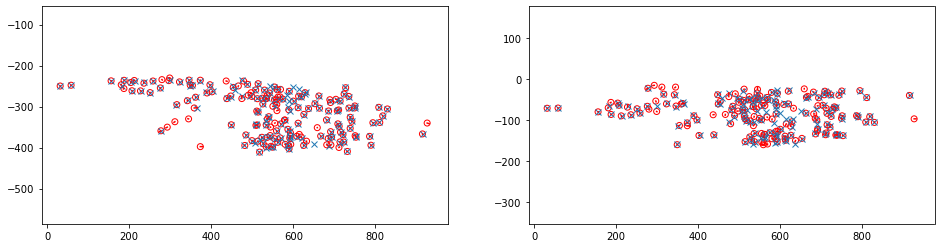

current volume: t= 1


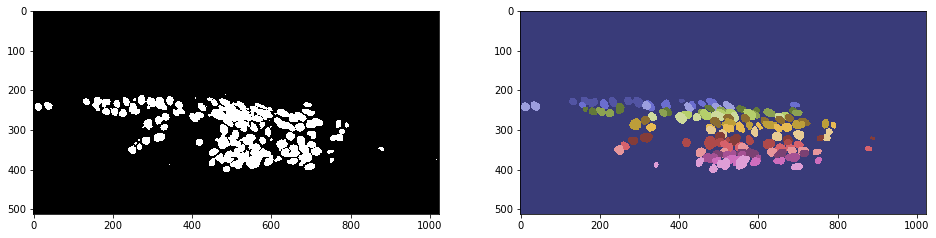

target volume: t= 50


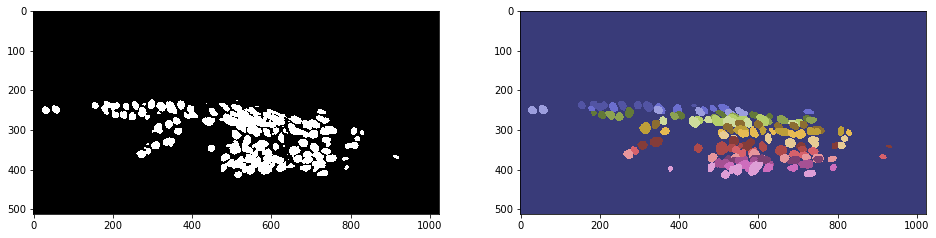

In [6]:
volume_test = 50
disp = match(volume, volume_test, par_image, par_tracker, par_path, par_subregions, r_coordinates_segment_pre,
             r_coordinates_tracked_pre, r_coordinates_tracked_pre_vol1, cells_on_boundary, unet_model,
             FFN_model, r_displacement_from_vol1, seg_cells_interpolated_corrected,
             np.max(image_cell_bg[0, :, :, :, 0], axis=2) > 0.5,
             np.max(seg_cells_interpolated_corrected, axis=2))

# Tracking following volumes

In [8]:
def save_tracking_info(r_coordinates_segment_pre, r_coordinates_tracked_pre, r_displacement_from_vol1):
    r_displacements.append(r_displacement_from_vol1)
    r_segmented_coordinates.append(r_coordinates_segment_pre)
    r_tracked_coordinates.append(r_coordinates_tracked_pre)


t_1 = time.time()
for volume in range(2, par_image["volume_num"] + 1):
    print('t=%i' % volume)

    # skip frames that cannot be tracked
    if volume in par_image["miss_frame"]:
        save_tracking_info(r_coordinates_segment_pre,
                           r_coordinates_tracked_pre, r_displacement_from_vol1)
        save_img3ts(range(1, par_image["z_siz"] + 1), l_label_T_watershed,
                    par_path["track_results_path"] + "track_results_t%04i_z%04i.tif", volume)
        continue

    # track cells and save the results
    l_label_T_watershed, r_coordinates_segment_pre, r_coordinates_tracked_pre, r_displacement_from_vol1 = \
        track_one_vol(volume, par_image, par_tracker, par_path, par_subregions, unet_model, FFN_model,
                      r_segmented_coordinates, r_tracked_coordinates, r_displacement_from_vol1,
                      r_coordinates_tracked_pre_vol1, seg_cells_interpolated_corrected, cells_on_boundary)

    # save tracking information
    save_tracking_info(r_coordinates_segment_pre,
                       r_coordinates_tracked_pre, r_displacement_from_vol1)

print('tracking all volumes took %.1f s' % (time.time() - t_1))

t=2
segmentation took 7.0 s
ref: 1, len of ref:1
fnn + pr-gls took 0.8 s
cells on boundary: []
max correction: 18.931251524503836,15.63558042123182,14.564757529364744,10.368693338304011,5.891542958808015,accurate correction of displacement took 7.2 s
t=3
segmentation took 6.8 s
ref: 2, len of ref:1
fnn + pr-gls took 0.8 s
cells on boundary: []
max correction: 4.970811485026162,4.454340516205491,13.894542511736072,13.21507115955539,7.590157608060508,accurate correction of displacement took 7.2 s
t=4
segmentation took 6.9 s
ref: 3, len of ref:1
fnn + pr-gls took 0.9 s
cells on boundary: []
max correction: 8.445481195328739,8.463393184256917,5.578370581111455,7.2819539508138575,10.214310472538095,accurate correction of displacement took 7.3 s
t=5
segmentation took 7.0 s
ref: 4, len of ref:1
fnn + pr-gls took 0.8 s
cells on boundary: []
max correction: 11.918345791005438,6.2219611286528576,8.60442248188078,2.6022102476765667,1.8601291387932761,accurate correction of displacement took 7.3 s

In [9]:
np.save(par_path["track_information_path"]+"r_displacements.npy",r_displacements)
np.save(par_path["track_information_path"]+"r_tracked_coordinates.npy",r_tracked_coordinates)
np.save(par_path["track_information_path"]+"r_segmented_coordinates.npy",r_segmented_coordinates)